In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
from utils.dynamics import import_dynamics
from utils.dataset_generator import generate_dataset

generate_dataset(system_name='2d', baseline=True)

[Dataset] Generating Dataset 2d


# Plotting and Comparison Trajectories

In [82]:
# baseline['rollout_len']
# baseline['rollout_len'], baseline['i_rollout'], baseline['dist_to_target'], baseline['x0']
f = open('datasets/dataset_2d_baseline_stats.pkl', 'rb')
b_stats = pickle.load(f)
f.close()

f = open('datasets/dataset_2d_baseline_data.pkl', 'rb')
b_data = pickle.load(f)
f.close()

f = open(f'inference/2d_arch256_e100_d100_edim256_ks5_par3_70e06_date04_26_02_22_20/data.pkl', 'rb')
data = pickle.load(f) # REWARD, TRAJECTORIES
f.close()

f = open(f'inference/2d_arch256_e100_d100_edim256_ks5_par3_70e06_date04_26_02_22_20/trajectories.pkl', 'rb')
traj = pickle.load(f) # REWARD, TRAJECTORIES
f.close()

finish = b_data['finish_token'].astype(np.int8)
episode_ends = np.array([idx for idx, a in enumerate(finish) if a == 1])
episode_ends = np.concatenate(([0], episode_ends))


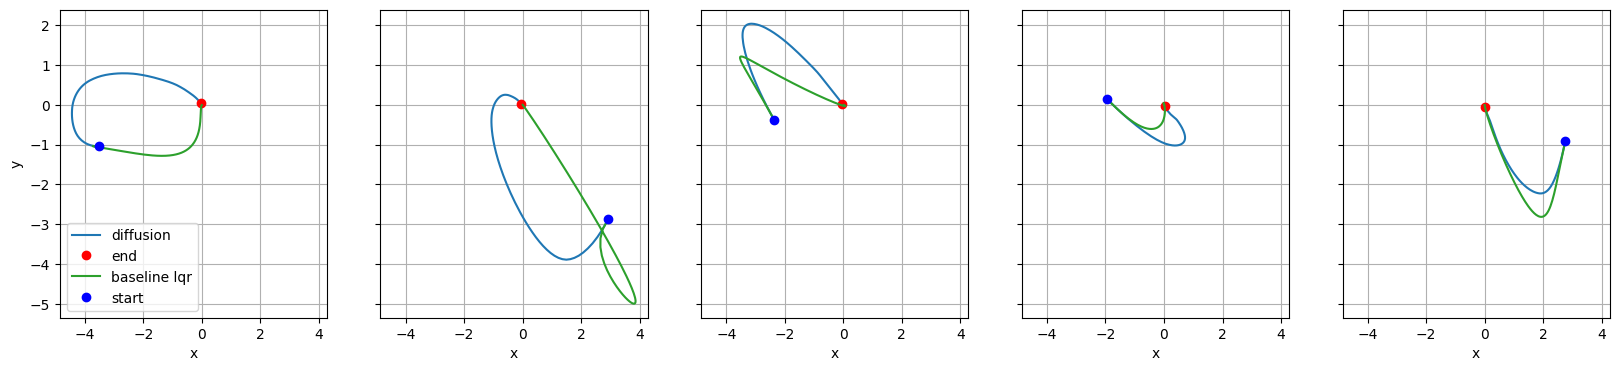

In [99]:
fig, axs = plt.subplots(1, 5, figsize = (20,4), sharex=True, sharey=True)
for i, ax in enumerate(axs):
    # data
    idx = i + 20
    tmp = np.array(traj[idx][0])
    ax.plot(tmp[:,0], tmp[:, 2], label = 'diffusion')

    ax.plot(tmp[0,0], tmp[0,2], '*')
    ax.plot(tmp[-1,0], tmp[-1,2], 'ro', label='end') # end

    x, _, y, _ = b_data['obs'][episode_ends[idx]+1:episode_ends[idx+1]].T
    ax.plot(x,y, label = 'baseline lqr')

    assert np.mean(b_stats['x0'][idx] - tmp[0]) < 1e-6 # same initial condition

    ax.plot(b_stats['x0'][idx,0] ,b_stats['x0'][idx,2], 'bo', label='start') #start
    ax.set_xlabel('x')
    ax.grid()

axs[0].set_ylabel('y')
axs[0].legend()

plt.savefig('2D_baseline_trajectories.pdf', bbox_inches = 'tight', pad_inches = 0)

# Baseline 500 average on 500


In [59]:
def one_rollout(A, B, x0_rollout, x_target_rollout, n_state, n_input, qr_seed):
    np.random.seed(qr_seed)
    Q = np.random.uniform(low=0.0, high=1.0, size=(n_state, n_state))
    Q = Q @ Q.T

    R = np.random.uniform(low=0.0, high=1.0, size=(n_input, n_input))
    R = R @ R.T

    # steady state lqr
    X = scipy.linalg.solve_discrete_are(A, B, Q, R)
    F = np.linalg.inv(R + B.T @ X @ B) @ B.T @ X @ A

    x_rollout = np.zeros((rollout_len, n_state))
    x_rollout[0] = x0_rollout
    u_rollout = np.zeros((rollout_len, n_input))
    for i_rollout in range(rollout_len):
        dist_to_target = np.linalg.norm(x_rollout[i_rollout] - x_target_rollout)

        if dist_to_target < finish_threshold or i_rollout == (rollout_len - 1):
            finish_token_rollout = i_rollout
            break
        u_rollout[i_rollout] = -F @ x_rollout[i_rollout]
        x_rollout[i_rollout + 1] = A @ x_rollout[i_rollout] + B @ u_rollout[i_rollout]

    # x_rollout,
    return finish_token_rollout

In [ ]:
A, B, x_target, n_state, n_input, name = import_dynamics(system_name='2d')

n_rand_controllers = 500  # how many random controllers we want to generate
rollout_len = 250  # how many time steps a rollout is
finish_threshold = 0.02  # stopping condition

load_results = True
if load_results:
    f = open(f'datasets/baseline_2d_500average_on500.pkl', 'rb')
    finish_step_avg = pickle.load(f) # REWARD, TRAJECTORIES
    f.close()
else:
    finish_step_avg = []
    for i_contr in range(n_rand_controllers):
        print(i_contr, end = ' ')
        np.random.seed(i_contr + 10000)


        x0 = np.random.uniform(low=-5.0, high=5.0, size=(n_state))

        finish_step = [one_rollout(A=A, B=B, x0_rollout=x0.T, x_target_rollout=x_target.T, n_state=n_state, n_input=n_input, qr_seed=jj+ int(3e4)) for jj in range(n_rand_controllers)]

        finish_step_avg.append(np.mean(finish_step))

    ## SAVE ##
    # with open(f'datasets/baseline_2d_500average_on500.pkl', 'wb') as handle:
    #     pickle.dump(finish_step_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # handle.close()

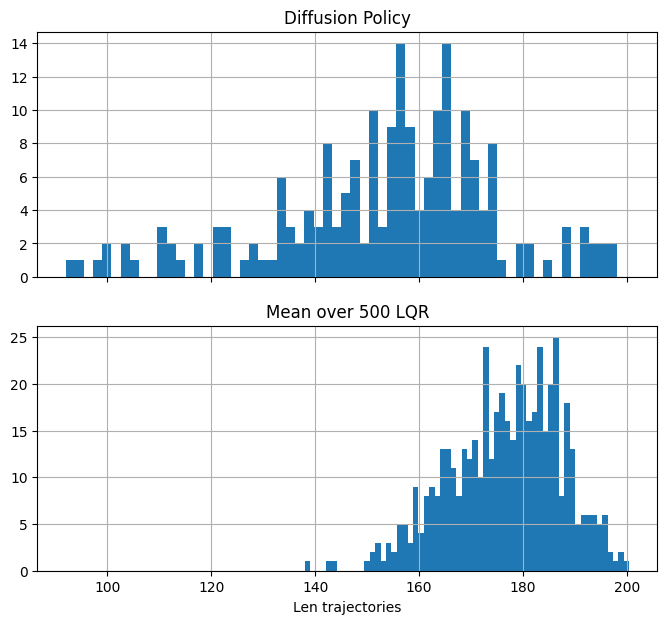

In [81]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,7), sharex=True)
ckpt_path = '2d_arch256_e100_d100_edim256_ks5_par3_70e06_date04_26_02_22_20'
f = open(f'inference/{ckpt_path}/data.pkl', 'rb')
data_loaded = pickle.load(f) # REWARD, TRAJECTORIES
f.close()
freq, thres, _x_ = ax1.hist(data_loaded[:,-1], bins = 60); #, orientation='horizontal');
ax1.set_title('Diffusion Policy')
ax1.grid()

ax2.hist(finish_step_avg, bins = 60);
ax2.set_xlabel('Len trajectories')
ax2.set_title('Mean over 500 LQR')
ax2.grid()
plt.savefig('2D_diffusion_vs_lqr.pdf', bbox_inches = 'tight', pad_inches = 0)
